# GOE 모델 빌드 및 학습

데이터 불러오기

In [2]:
from google.colab import drive
from tensorflow.keras.models import load_model
import numpy as np
import time # 인풋데이터를 섞기 위한 랜덤시드를 위해!
import pickle # 평균과 표준편차를 피클파일로 저장하기 위해!

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


데이터 로드

In [0]:
class Data:
    def __init__(self): # X는 생 파일 x는 전처리 이후 사용가능한 파일
        X_train = np.load('/content/gdrive/My Drive/GOE/Xtrain.npy')
        y_train = np.load('/content/gdrive/My Drive/GOE/Ytrain.npy')
        X_test = np.load('/content/gdrive/My Drive/GOE/Xtest.npy')
        y_test = np.load('/content/gdrive/My Drive/GOE/Ytest.npy')

        np.random.seed(int(time.time()))

        # 배열 섞기
        s = np.arange(X_train.shape[0])
        np.random.shuffle(s)
        X_train = X_train[s]
        y_train = y_train[s]

        mean = X_train.mean(axis=0)
        x_train = X_train - mean
        std = x_train.std(axis=0)
        x_train /= std

        x_test = (X_test - mean) / std

        with open('/content/gdrive/My Drive/GOE/mean.pickle', 'wb') as f:
            pickle.dump(mean, f, pickle.HIGHEST_PROTOCOL)
        with open('/content/gdrive/My Drive/GOE/std.pickle', 'wb') as f:
            pickle.dump(std, f, pickle.HIGHEST_PROTOCOL)

        self.mean = mean
        self.std = std
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.x_shape = x_test.shape[1]
        self.y_shape = y_test.shape[1]
        self.X_train = X_train
        self.X_test = X_test

학습 그래프 함수 정의

In [0]:
import matplotlib.pyplot as plt

def plot_graph(history, yname, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    if yname == 'acc':
        plt.plot(history['acc']) # 선 그리기
        plt.plot(history['val_acc'])
        plt.ylabel('Accuracy') # y축 이름 표시
    else:
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.ylabel('Loss') # y축 이름 표시
        
    if title is not None:
        plt.title(title) # 그래프 제목 표시
    
    plt.xlabel('Epoch') # x축 이름 표시
    plt.legend(['Training', 'Verification'], loc=0) # 각 라인의 표식 표시
    plt.show()

모델 정의

In [5]:
import keras
from keras import layers
from keras.models import Sequential

def build_model(input_size, output_size):
    m = Sequential()
    m.add(layers.Dense(16, activation='relu', input_shape=(input_size,)))
    m.add(layers.Dense(64, activation='relu'))
    m.add(layers.Dense(128, activation='relu'))
    m.add(layers.Dropout(0.2))
    m.add(layers.Dense(256, activation='relu'))
    # m.add(layers.LSTM(256, input_shape=(input_size,)))


    m.add(layers.Dense(output_size, activation='sigmoid'))
    # m.add(layers.Dense(output_size, activation='relu'))

    m.compile(loss='mse', optimizer='adam')

    return m

Using TensorFlow backend.


K-겹 교차검증 기법

In [0]:
from math import ceil

class K_Fold_Cross():
    def __init__(self, K=5):
        self.data = Data()
        self.models = [build_model(self.data.x_shape, self.data.y_shape) for _ in range(K)]
        print(self.models)
        self.K = K

    def run(self):
        data = self.data
        K = self.K
        split_ratio = len(data.x_train) // K
        performance_list = []
        models = self.models
        loss_list = []
        val_loss_list = []

        for i in range(K):
            print('train', i+1)
            x_train = np.array(list(data.x_train[ : i*split_ratio]) + list(data.x_train[(i+1)*split_ratio : ]))
            x_verification = data.x_train[i*split_ratio : (i+1)*split_ratio]

            y_train = np.array(list(data.y_train[ : i*split_ratio]) + list(data.y_train[(i+1)*split_ratio : ]))
            y_verification = data.y_train[i*split_ratio : (i+1)*split_ratio]

            history = models[i].fit(x_train, y_train, epochs=30, batch_size=5, verbose=0, validation_data=(x_verification, y_verification))

            performance_list.append(models[i].evaluate(data.x_test, data.y_test, batch_size=5))
            if not isinstance(history, dict):
                loss_list.append(np.array(history.history['loss']))
                val_loss_list.append(np.array(history.history['val_loss']))

        loss = np.zeros(loss_list[0].shape)
        val_loss = np.zeros(val_loss_list[0].shape)

        for l, vl in zip(loss_list, val_loss_list):
            loss += l
            val_loss += vl

        self.loss = loss / K
        self.val_loss = val_loss / K
        self.performance = sum(performance_list) / K
        self.models = models

        print('\nTest Loss -> {:.2f}'.format(self.performance))

    def preprocessing(self, input_data):
        return (np.array(input_data) - self.data.mean) / self.data.std

    def predict(self, input_data):
        preprocessed_data = self.preprocessing(input_data)
        predict_list = []

        for i in range(self.K):
            pred = self.models[i].predict(preprocessed_data)
            predict_list.append(np.array([list(map(lambda x:1 if x >= 0.5 else 0, p)) for p in pred]))
        
        predict_sum = np.zeros(predict_list[0].shape)
        # list(map(lambda x:1 if x >= ceil(self.K / 2) else 0, pl)) for pl in predict_list
        for pred in predict_list:
            predict_sum += pred
        
        return [list(map(lambda x:1 if x >= ceil(self.K / 2) else 0, pred)) for pred in predict_sum]
    
    def save(self, link='/content/gdrive/My Drive/GOE/k_cross/'):
        for i in range(self.K):
            self.models[i].save(link + 'k_cross_model' + str(i+1) + '.h5')

실행

In [19]:
data = Data()
model = build_model(data.x_shape, data.y_shape)
model.summary()
history = model.fit(data.x_train, data.y_train, epochs=30, batch_size=5, validation_split=0.2, verbose=0)

performance_test = model.evaluate(data.x_test, data.y_test, batch_size=5)
print('\nTest Loss -> {:.2f}'.format(performance_test))

if not isinstance(history, dict):
    history = history.history

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_22 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_23 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_25 (Dense)             (None, 96)                24672     
Total params: 67,184
Trainable params: 67,184
Non-trainable params: 0
__________________________________________________

K - 겹 교차검증 모델 실행

In [66]:
k_cross = K_Fold_Cross()
k_cross.run()

[<keras.engine.sequential.Sequential object at 0x7fb74116da90>, <keras.engine.sequential.Sequential object at 0x7fb7400defd0>, <keras.engine.sequential.Sequential object at 0x7fb74005ada0>, <keras.engine.sequential.Sequential object at 0x7fb73dffecc0>, <keras.engine.sequential.Sequential object at 0x7fb73df5b860>]
train 1
30/30 [==============================] - 0s 678us/step
train 2
30/30 [==============================] - 0s 683us/step
train 3
30/30 [==============================] - 0s 590us/step
train 4
30/30 [==============================] - 0s 583us/step
train 5
30/30 [==============================] - 0s 706us/step

Test Loss -> 0.01


그래프 그리기

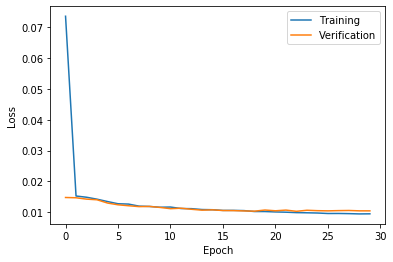

In [35]:
plot_graph(history, 'loss')

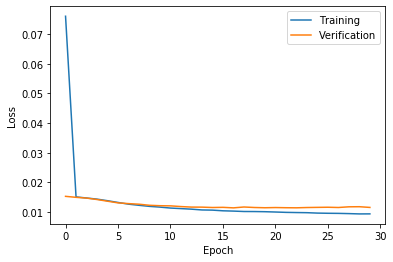

In [67]:
plt.plot(k_cross.loss)
plt.plot(k_cross.val_loss)
plt.ylabel('Loss') # y축 이름 표시
plt.xlabel('Epoch') # x축 이름 표시
plt.legend(['Training', 'Verification'], loc=0) # 각 라인의 표식 표시
plt.show()

학습된 모델로 예측

In [68]:
s = np.arange(data.x_train.shape[0])
np.random.shuffle(s)

raw_d = data.X_train[s[:10]]
d = data.x_train[s[:10]]
# print(raw_d)

pred = k_cross.predict(raw_d)
for i, p in enumerate(pred):
    print(raw_d[i])
    print(p[:48])
    print(p[48:])

[ 5.  1. 17.  1.]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[ 4.   3.  17.8  3. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[12.   2.  11.5  3. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[ 3.  2. 11.  2.]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [48]:
pred = model.predict(d)
for i, p in enumerate(pred):
    print(raw_d[i])
    p = list(map(lambda x:1 if x >= 0.5 else 0, p))
    print(p[:48])
    print(p[48:])

[12.   6.   5.6  2. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[ 9.   2.  17.6  1. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[11.   7.  11.9  3. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3. 2. 8. 2.]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

모델 저장

In [0]:
model.save('/content/gdrive/My Drive/GOE/model.h5')
k_cross.save()